Welcome to the DL in Inverse Scattering Tutorial. Through this notebook, we aim to provide a step-by-step introduction to codes used in implemenation of the scheme provided in <i>Embedding Deep Learning in Inverse Scattering Problem</i>. After going through this notebook, one can perform the numerical experiments themselves to generate the results presented in our aforementioned paper. 

The link to original paper can be found <a href = "https://ieeexplore.ieee.org/document/8709721">here</a>. We have also provided a link to slides of corresponding conference paper presented at URSI-APRASC 2019 Delhi <a href="https://sanghviyashiitb.github.io/blog/2019-3-31-URSI">here</a>.


To start off, we firstly need to initialize some problem parameters. Since our scheme is heavily using Subspace Optimization Method (SOM), we use the parameters as ones used in the original SOM paper i.e. <a href = "https://ieeexplore.ieee.org/abstract/document/5210141">Subspace-Based Optimization Method for Solving Inverse-Scattering Problems</a>.

The imaging domain, $D$, is assumed to be of size $2m \times 2m$ and the object of interest is located within this domain. The incident field is $400MHz$, and hence the free space wavelength is $\lambda = 0.75m$. The measurements are taken on a circle of radius $R_S = 4m$ with the centre of the circle coinciding with the center of $D$ and $N_s = 32$ receivers are placed along the measurement domain in an equiangular manner for each illuminations. Total number of different illuminations are $N_I = 16$ and the corresponding transceivers are placed on the radius $R_i = 6m$.

In [1]:
import sys
sys.path.insert(0, './utility/')
sys.path.insert(0, './SOM_CSI/')
import numpy as np
import generate_shapes
import matplotlib.pyplot as plt

# Frequency = 400MHz
f = 4e8
wavelength = 3e8/f

# k := Wavenumber
k = 2*np.pi/wavelength 

# d := Dimension of imaging domain D in meters
d = 2 

# R := Radius of measurement domain
R = 4

# M := Number of Receivers per illumination
M = 32

# V := Number of illuminations
V = 16

Given these paramters, we can generate other quantities such as positions of discretized grids, receivers and transceivers. Additionally, we also need the incident field vector for the inverse scattering problem

In [2]:
import setup_functions

# The imaging domain is discretized into L X L cells
L = 32 
# Dimension of one cell
n = d/L 
# Number of pixels
N = L^2

# Positions of center of each grid. Shape = [N, 2]
# pos_D[i,:] = [x coordinate, y coordinate] of cell #i 
pos_D = setup_functions.gen_pos_D(d,L,n)

# Positions of Receivers and Transceivers. Shape = [M,2] and [V,2] respectively
# pos_S[i,:] = [x coordinate, y coordinate] of receiver #i 
pos_S = setup_functions.gen_pos_S(R, M, d) 
# pos_Tx[i,:] = [x coordinate, y coordinate] of transceiver #i 
pos_Tx = setup_functions.gen_pos_Tx(R*1.5, V, d)

# Incident Field, Shape = [N,1] (Complex vector)
e = setup_functions.gen_e(k, pos_D, pos_Tx)

Next, we need the scattered fields which will be used to obtain the dielectric profile. In absence of actual data, we simulate the experimental data by running the forward solver at a higher resolution ($L = 100$) in this case. 

In [3]:
# For forward solver
L_forward = 32
n_forward = d/L_forward

pos_D_forward = setup_functions.gen_pos_D(d,L_forward,n_forward)
e_forward = setup_functions.gen_e(k, pos_D_forward, pos_Tx)

We use the CG-FFT forward solver to find out the internal fields and then calculate the scattered fields at external points using the matrix $G_S$. The process can be summarized as follows:
$$d_n =  e_n + G_DXe_n$$
$$\Rightarrow w_n = Xe_n + XG_Dw_n$$
$$ s_n = G_S w_n $$

Note that the symbols used have the same meaning as those defined in our paper.

In [4]:
import util_cgfft
import util_functions
# Forward Solver parameters for L = 100 
# FFT representation of G_D matrix
g_D_forward, g_D_fft_forward, g_D_fft_conj_forward = util_cgfft.construct_g_D(pos_D_forward, k, n_forward)

# G_S matrix for forward solver
G_S_forward = util_functions.construct_G_S(pos_D_forward, pos_S, k, n_forward)

# Forward Solver parameters for L = 32 
G_D = util_functions.construct_G_D(pos_D, k, n)
# FFT representation of G_D matrix
g_D, g_D_fft, g_D_fft_conj = util_cgfft.construct_g_D(pos_D, k, n)

# G_S matrix for inverse solver solver
G_S = util_functions.construct_G_S(pos_D, pos_S, k, n)


############################################################# 
# Generating parameters for Inversion at 16 X 16 Resolution
#############################################################
L1 = 16
n_L1 = d/L1

pos_D_L1 = setup_functions.gen_pos_D(d,L1,n_L1)
e_L1 = setup_functions.gen_e(k, pos_D_L1, pos_Tx)

g_D_L1, g_D_fft_L1, g_D_fft_conj_L1 = util_cgfft.construct_g_D(pos_D_L1, k, n_L1)
G_S_L1 = util_functions.construct_G_S(pos_D_L1, pos_S, k, n_L1)
G_D_L1 = util_functions.construct_G_D(pos_D_L1, k, n_L1)

## Ignore the warning which comes after running the code

/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


But what object we are going to run the forward solver on? We use the Austria profile which is often used to validate inverse scattering algorithms. However, we increase the contrast of the profile to make an electrically stronger object for which conventional algorithms fail

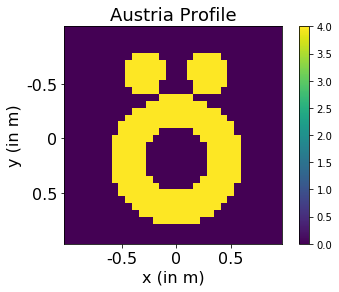

In [5]:

max_contrast = 4.0
x_au = generate_shapes.austria_multicontrast(L_forward,max_contrast,max_contrast,max_contrast)

# Display Austria Profile
plt.imshow(np.real(x_au))
plt.xticks([L_forward*0.25, L_forward*0.5, L_forward*0.75], [-0.5, 0, 0.5],fontsize = '16')
plt.yticks([L_forward*0.25, L_forward*0.5, L_forward*0.75], [-0.5, 0, 0.5],fontsize = '16')
plt.xlabel('x (in m)', fontsize='16')
plt.ylabel('y (in m)', fontsize='16')
plt.title('Austria Profile', fontsize='18')
plt.colorbar()

The CG-FFT solver is used to generate scattered field data which will be later used in the inversion process.

In [6]:
# Generating scattered field from profile
# Reshape profile into [N,1] vector
x = np.reshape(x_au,[L_forward*L_forward,1])
# Run the forward solver
print('Running Forward Solver for %d illuminations'%(V))
print('This might take a while...')
y, _ = util_cgfft.cg_fft_forward_problem(x, G_S_forward, g_D_fft_forward, e_forward, 1e-6, e_forward, 1000)
# Add 25dB Gaussian Noise
print('Completed running the solver.')
y = util_functions.add_noise(y, 25)

Running Forward Solver for 16 illuminations
This might take a while...


/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Tolerance = 0.430e-6 at iteration = 210 for 1th illumination
Tolerance = 0.873e-6 at iteration = 216 for 2th illumination
Tolerance = 0.536e-6 at iteration = 218 for 3th illumination
Tolerance = 0.153e-6 at iteration = 217 for 4th illumination
Tolerance = 0.584e-6 at iteration = 122 for 5th illumination
Tolerance = 0.129e-6 at iteration = 216 for 6th illumination
Tolerance = 0.630e-6 at iteration = 221 for 7th illumination
Tolerance = 0.285e-6 at iteration = 218 for 8th illumination
Tolerance = 0.739e-6 at iteration = 212 for 9th illumination
Tolerance = 0.130e-6 at iteration = 220 for 10th illumination
Tolerance = 0.560e-6 at iteration = 226 for 11th illumination
Tolerance = 0.667e-6 at iteration = 215 for 12th illumination
Tolerance = 0.835e-6 at iteration = 122 for 13th illumination
Tolerance = 0.714e-6 at iteration = 213 for 14th illumination
Tolerance = 0.549e-6 at iteration = 215 for 15th illumination
Tolerance = 0.438e-6 at iteration = 215 for 16th illumination
Completed running

Firstly, we try to reconstruct the original profile from scattered field through plain SOM. As we'll see, the reconstruction would fail as the underlying object is too small. 

In [8]:
############################################# 
# Running SOM Solver at 32 X 32 Resolution
#############################################
from SOM import SOM_SingularValues_Morozov, SOM_Stage_II_CGFFT_TV, TSOM_withCGFFT_TV

# SVD of G_S, used in extracting row-space components
U1, s1, V1h = np.linalg.svd(G_S, full_matrices=False)
S1 = np.diag(s1)
V1 = V1h.conj().T
# Extract row space components from scattered field data
w_RS, _ = SOM_SingularValues_Morozov(y, G_S, U1, S1, V1, 25)
# Convert w_RS to equivalent contrast
d_0 =  e + util_cgfft.G_D_into_x(g_D_fft, w_RS)
x_RS = np.reshape( np.sum(d_0.conj()*w_RS, axis = 1)/np.sum(d_0.conj()*d_0,axis=1), (L*L,1) )
# Use TSOM+TV to extract the 
x_L2, _, _ = TSOM_withCGFFT_TV(y, G_S, G_D, g_D_fft, g_D_fft_conj, e, w_RS, 0, False, 500, 2000, 25, 1e-4)
x_L2 = np.real(x_L2)*(np.real(x_L2) >= 0) + 1j*np.imag(x_L2)*(np.imag(x_L2) <= 0)



Number of Singular Values used: 20
Number of Singular Values used: 20


/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


ADMM_Elapsed Time: 0.573
Iteration: 0, Cost function: 12.25392
SOM Iteration time: 0.761
ADMM_Elapsed Time: 0.102
Iteration: 1, Cost function: 10.50095
SOM Iteration time: 0.340
ADMM_Elapsed Time: 0.063
Iteration: 2, Cost function: 9.20113
SOM Iteration time: 0.294
ADMM_Elapsed Time: 0.072
Iteration: 3, Cost function: 8.45320
SOM Iteration time: 0.299
ADMM_Elapsed Time: 0.070
Iteration: 4, Cost function: 7.85525
SOM Iteration time: 0.310
ADMM_Elapsed Time: 0.064
Iteration: 5, Cost function: 7.30990
SOM Iteration time: 0.267
ADMM_Elapsed Time: 0.075
Iteration: 6, Cost function: 7.00192
SOM Iteration time: 0.286
ADMM_Elapsed Time: 0.075
Iteration: 7, Cost function: 6.72420
SOM Iteration time: 0.308
ADMM_Elapsed Time: 0.066
Iteration: 8, Cost function: 6.47199
SOM Iteration time: 0.295
ADMM_Elapsed Time: 0.064
Iteration: 9, Cost function: 6.31577
SOM Iteration time: 0.273
ADMM_Elapsed Time: 0.064
Iteration: 10, Cost function: 6.12426
SOM Iteration time: 0.322
ADMM_Elapsed Time: 0.063
Iter

KeyboardInterrupt: 

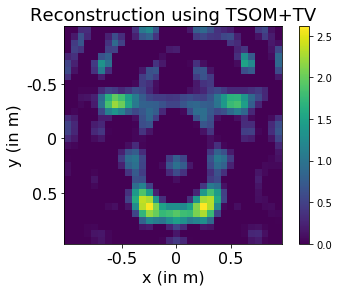

In [9]:
# Display Reconstruction of Austria Profile
plt.imshow(np.real(np.reshape(x_L2,[L,L])))
plt.xticks([L*0.25, L*0.5, L*0.75], [-0.5, 0, 0.5],fontsize = '16')
plt.yticks([L*0.25, L*0.5, L*0.75], [-0.5, 0, 0.5],fontsize = '16')
plt.xlabel('x (in m)', fontsize='16')
plt.ylabel('y (in m)', fontsize='16')
plt.title('Reconstruction using TSOM+TV', fontsize='18')
plt.colorbar()

As it might be clear from the reconstruction using SOM, Austria contrast 4 profile is too strong an object to recover. The original shape (a ring and 2 disks) is not recovered and the contrast of the reconstructed object is also too low.  

Our method provides a way to circumvent this issue. The idea is to learn and use the underlying prior of the object to get a better estimate the null subspace of the contrast source. This estimate is further refined by optimizing the cost function used in SOM,by using the null-space estimate as an initialization.

To start with, lets obtain the row space coefficient of the contrast source at a 16X16 discretization of the imaging domain.

In [10]:
# SVD of G_S, used in extracting row-space components
U1, s1, V1h = np.linalg.svd(G_S_L1, full_matrices=False)
S1 = np.diag(s1)
V1 = V1h.conj().T

# Extract row space components from scattered field data
w_RS_L1, _ = SOM_SingularValues_Morozov(y, G_S_L1, U1, S1, V1, 25)

Number of Singular Values used: 20


Now that we have a rowspace component, we use a novel convolutional network <i>CS-Net</i> which is trained to predict the noise subspace from the row subspace component of the contrast source. In the following snippet of code, we load a pre-trained CS-Net model and push the signal subspace of the contrast source to it. At the end, we get a prediction of the noise-space. 

In [11]:
import torch
from ContrastSourceNet import ContrastSourceNet_16_MultiScale_2

# Load the trained CS-Net
MODEL_L16_FILE = './best_models_yet/ContrastSourceNet_noisydata_25SNR_L16.pth'
cs_net = ContrastSourceNet_16_MultiScale_2(V)
cs_net.load_state_dict(torch.load(MODEL_L16_FILE))

CSImage_input_L1 = np.expand_dims( util_functions.convert_w_to_CSImage(w_RS_L1),axis = 0) 
CSImage_output_L1 = cs_net( torch.Tensor(CSImage_input_L1) ).detach().numpy()
w_DL = util_functions.convert_CSImage_to_w(np.squeeze(CSImage_output_L1, axis=0))

The total contrast source is used to initialize optimization of the SOM cost function, effectively avoiding the local minima which is often an issue while recovering the electrically strong objects.

In [12]:
d_0 =  e_L1 + util_cgfft.G_D_into_x(g_D_fft_L1, w_DL)
x_DL = np.reshape( np.sum(d_0.conj()*w_DL, axis = 1)/np.sum(d_0.conj()*d_0,axis=1), (L1*L1,1) )
x_DL_SOM, w_DL_SOM, _ = TSOM_withCGFFT_TV(y, G_S_L1, G_D_L1, g_D_fft_L1, g_D_fft_conj_L1, e_L1, w_DL, x_DL, False, 256, 2000, 25, 0)


/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Number of Singular Values used: 20
Iteration: 0, Cost function: 155.30070
SOM Iteration time: 0.061
Iteration: 1, Cost function: 119.90346
SOM Iteration time: 0.066
Iteration: 2, Cost function: 100.63564
SOM Iteration time: 0.051
Iteration: 3, Cost function: 87.67580
SOM Iteration time: 0.051
Iteration: 4, Cost function: 78.16282
SOM Iteration time: 0.051
Iteration: 5, Cost function: 68.16580
SOM Iteration time: 0.050
Iteration: 6, Cost function: 59.10711
SOM Iteration time: 0.065
Iteration: 7, Cost function: 51.88843
SOM Iteration time: 0.051
Iteration: 8, Cost function: 45.12823
SOM Iteration time: 0.050
Iteration: 9, Cost function: 39.09899
SOM Iteration time: 0.051
Iteration: 10, Cost function: 34.55038
SOM Iteration time: 0.057
Iteration: 11, Cost function: 30.59922
SOM Iteration time: 0.061
Iteration: 12, Cost function: 27.83788
SOM Iteration time: 0.051
Iteration: 13, Cost function: 25.83043
SOM Iteration time: 0.050
Iteration: 14, Cost function: 24.06282
SOM Iteration time: 0.0

Iteration: 129, Cost function: 2.74424
SOM Iteration time: 0.094
Iteration: 130, Cost function: 2.71914
SOM Iteration time: 0.082
Iteration: 131, Cost function: 2.69070
SOM Iteration time: 0.063
Iteration: 132, Cost function: 2.66525
SOM Iteration time: 0.058
Iteration: 133, Cost function: 2.63854
SOM Iteration time: 0.066
Iteration: 134, Cost function: 2.61293
SOM Iteration time: 0.057
Iteration: 135, Cost function: 2.58728
SOM Iteration time: 0.057
Iteration: 136, Cost function: 2.56269
SOM Iteration time: 0.062
Iteration: 137, Cost function: 2.53998
SOM Iteration time: 0.053
Iteration: 138, Cost function: 2.51538
SOM Iteration time: 0.052
Iteration: 139, Cost function: 2.49320
SOM Iteration time: 0.054
Iteration: 140, Cost function: 2.47071
SOM Iteration time: 0.064
Iteration: 141, Cost function: 2.44883
SOM Iteration time: 0.055
Iteration: 142, Cost function: 2.42687
SOM Iteration time: 0.050
Iteration: 143, Cost function: 2.40602
SOM Iteration time: 0.067
Iteration: 144, Cost func

Iteration: 258, Cost function: 1.18142
SOM Iteration time: 0.076
Iteration: 259, Cost function: 1.17515
SOM Iteration time: 0.056
Iteration: 260, Cost function: 1.16904
SOM Iteration time: 0.059
Iteration: 261, Cost function: 1.16329
SOM Iteration time: 0.054
Iteration: 262, Cost function: 1.15742
SOM Iteration time: 0.060
Iteration: 263, Cost function: 1.15244
SOM Iteration time: 0.104
Iteration: 264, Cost function: 1.14706
SOM Iteration time: 0.056
Iteration: 265, Cost function: 1.14229
SOM Iteration time: 0.063
Iteration: 266, Cost function: 1.13770
SOM Iteration time: 0.125
Iteration: 267, Cost function: 1.13287
SOM Iteration time: 0.124
Iteration: 268, Cost function: 1.12814
SOM Iteration time: 0.102
Iteration: 269, Cost function: 1.12355
SOM Iteration time: 0.064
Iteration: 270, Cost function: 1.11867
SOM Iteration time: 0.068
Iteration: 271, Cost function: 1.11372
SOM Iteration time: 0.066
Iteration: 272, Cost function: 1.10899
SOM Iteration time: 0.056
Iteration: 273, Cost func

Iteration: 387, Cost function: 0.76229
SOM Iteration time: 0.168
Iteration: 388, Cost function: 0.76037
SOM Iteration time: 0.056
Iteration: 389, Cost function: 0.75859
SOM Iteration time: 0.055
Iteration: 390, Cost function: 0.75678
SOM Iteration time: 0.056
Iteration: 391, Cost function: 0.75485
SOM Iteration time: 0.071
Iteration: 392, Cost function: 0.75308
SOM Iteration time: 0.097
Iteration: 393, Cost function: 0.75119
SOM Iteration time: 0.056
Iteration: 394, Cost function: 0.74952
SOM Iteration time: 0.058
Iteration: 395, Cost function: 0.74771
SOM Iteration time: 0.080
Iteration: 396, Cost function: 0.74573
SOM Iteration time: 0.104
Iteration: 397, Cost function: 0.74387
SOM Iteration time: 0.162
Iteration: 398, Cost function: 0.74210
SOM Iteration time: 0.137
Iteration: 399, Cost function: 0.74028
SOM Iteration time: 0.125
Iteration: 400, Cost function: 0.73850
SOM Iteration time: 0.052
Iteration: 401, Cost function: 0.73680
SOM Iteration time: 0.053
Iteration: 402, Cost func

Iteration: 517, Cost function: 0.57959
SOM Iteration time: 0.058
Iteration: 518, Cost function: 0.57849
SOM Iteration time: 0.065
Iteration: 519, Cost function: 0.57741
SOM Iteration time: 0.137
Iteration: 520, Cost function: 0.57629
SOM Iteration time: 0.154
Iteration: 521, Cost function: 0.57510
SOM Iteration time: 0.124
Iteration: 522, Cost function: 0.57405
SOM Iteration time: 0.067
Iteration: 523, Cost function: 0.57294
SOM Iteration time: 0.064
Iteration: 524, Cost function: 0.57179
SOM Iteration time: 0.061
Iteration: 525, Cost function: 0.57076
SOM Iteration time: 0.054
Iteration: 526, Cost function: 0.56968
SOM Iteration time: 0.058
Iteration: 527, Cost function: 0.56867
SOM Iteration time: 0.071
Iteration: 528, Cost function: 0.56769
SOM Iteration time: 0.064
Iteration: 529, Cost function: 0.56663
SOM Iteration time: 0.060
Iteration: 530, Cost function: 0.56566
SOM Iteration time: 0.092
Iteration: 531, Cost function: 0.56470
SOM Iteration time: 0.093
Iteration: 532, Cost func

Iteration: 645, Cost function: 0.47150
SOM Iteration time: 0.060
Iteration: 646, Cost function: 0.47079
SOM Iteration time: 0.057
Iteration: 647, Cost function: 0.47019
SOM Iteration time: 0.051
Iteration: 648, Cost function: 0.46953
SOM Iteration time: 0.051
Iteration: 649, Cost function: 0.46892
SOM Iteration time: 0.052
Iteration: 650, Cost function: 0.46825
SOM Iteration time: 0.058
Iteration: 651, Cost function: 0.46763
SOM Iteration time: 0.052
Iteration: 652, Cost function: 0.46706
SOM Iteration time: 0.050
Iteration: 653, Cost function: 0.46654
SOM Iteration time: 0.055
Iteration: 654, Cost function: 0.46594
SOM Iteration time: 0.055
Iteration: 655, Cost function: 0.46541
SOM Iteration time: 0.050
Iteration: 656, Cost function: 0.46484
SOM Iteration time: 0.051
Iteration: 657, Cost function: 0.46423
SOM Iteration time: 0.061
Iteration: 658, Cost function: 0.46369
SOM Iteration time: 0.056
Iteration: 659, Cost function: 0.46308
SOM Iteration time: 0.050
Iteration: 660, Cost func

Iteration: 773, Cost function: 0.40574
SOM Iteration time: 0.118
Iteration: 774, Cost function: 0.40535
SOM Iteration time: 0.098
Iteration: 775, Cost function: 0.40496
SOM Iteration time: 0.102
Iteration: 776, Cost function: 0.40455
SOM Iteration time: 0.074
Iteration: 777, Cost function: 0.40415
SOM Iteration time: 0.057
Iteration: 778, Cost function: 0.40374
SOM Iteration time: 0.076
Iteration: 779, Cost function: 0.40332
SOM Iteration time: 0.059
Iteration: 780, Cost function: 0.40293
SOM Iteration time: 0.085
Iteration: 781, Cost function: 0.40251
SOM Iteration time: 0.070
Iteration: 782, Cost function: 0.40207
SOM Iteration time: 0.059
Iteration: 783, Cost function: 0.40166
SOM Iteration time: 0.067
Iteration: 784, Cost function: 0.40124
SOM Iteration time: 0.074
Iteration: 785, Cost function: 0.40078
SOM Iteration time: 0.064
Iteration: 786, Cost function: 0.40033
SOM Iteration time: 0.061
Iteration: 787, Cost function: 0.39985
SOM Iteration time: 0.062
Iteration: 788, Cost func

Iteration: 901, Cost function: 0.36047
SOM Iteration time: 0.068
Iteration: 902, Cost function: 0.36017
SOM Iteration time: 0.108
Iteration: 903, Cost function: 0.35987
SOM Iteration time: 0.066
Iteration: 904, Cost function: 0.35958
SOM Iteration time: 0.065
Iteration: 905, Cost function: 0.35931
SOM Iteration time: 0.085
Iteration: 906, Cost function: 0.35904
SOM Iteration time: 0.057
Iteration: 907, Cost function: 0.35877
SOM Iteration time: 0.055
Iteration: 908, Cost function: 0.35848
SOM Iteration time: 0.085
Iteration: 909, Cost function: 0.35819
SOM Iteration time: 0.095
Iteration: 910, Cost function: 0.35791
SOM Iteration time: 0.055
Iteration: 911, Cost function: 0.35762
SOM Iteration time: 0.054
Iteration: 912, Cost function: 0.35732
SOM Iteration time: 0.107
Iteration: 913, Cost function: 0.35703
SOM Iteration time: 0.103
Iteration: 914, Cost function: 0.35676
SOM Iteration time: 0.105
Iteration: 915, Cost function: 0.35648
SOM Iteration time: 0.084
Iteration: 916, Cost func

Iteration: 1030, Cost function: 0.32669
SOM Iteration time: 0.067
Iteration: 1031, Cost function: 0.32647
SOM Iteration time: 0.067
Iteration: 1032, Cost function: 0.32623
SOM Iteration time: 0.062
Iteration: 1033, Cost function: 0.32598
SOM Iteration time: 0.068
Iteration: 1034, Cost function: 0.32575
SOM Iteration time: 0.063
Iteration: 1035, Cost function: 0.32550
SOM Iteration time: 0.113
Iteration: 1036, Cost function: 0.32525
SOM Iteration time: 0.128
Iteration: 1037, Cost function: 0.32502
SOM Iteration time: 0.098
Iteration: 1038, Cost function: 0.32477
SOM Iteration time: 0.089
Iteration: 1039, Cost function: 0.32454
SOM Iteration time: 0.083
Iteration: 1040, Cost function: 0.32432
SOM Iteration time: 0.072
Iteration: 1041, Cost function: 0.32410
SOM Iteration time: 0.067
Iteration: 1042, Cost function: 0.32389
SOM Iteration time: 0.065
Iteration: 1043, Cost function: 0.32370
SOM Iteration time: 0.068
Iteration: 1044, Cost function: 0.32348
SOM Iteration time: 0.067
Iteration:

Iteration: 1155, Cost function: 0.30163
SOM Iteration time: 0.064
Iteration: 1156, Cost function: 0.30142
SOM Iteration time: 0.058
Iteration: 1157, Cost function: 0.30123
SOM Iteration time: 0.058
Iteration: 1158, Cost function: 0.30104
SOM Iteration time: 0.066
Iteration: 1159, Cost function: 0.30084
SOM Iteration time: 0.068
Iteration: 1160, Cost function: 0.30065
SOM Iteration time: 0.063
Iteration: 1161, Cost function: 0.30045
SOM Iteration time: 0.065
Iteration: 1162, Cost function: 0.30027
SOM Iteration time: 0.063
Iteration: 1163, Cost function: 0.30009
SOM Iteration time: 0.065
Iteration: 1164, Cost function: 0.29992
SOM Iteration time: 0.061
Iteration: 1165, Cost function: 0.29975
SOM Iteration time: 0.069
Iteration: 1166, Cost function: 0.29957
SOM Iteration time: 0.067
Iteration: 1167, Cost function: 0.29939
SOM Iteration time: 0.068
Iteration: 1168, Cost function: 0.29923
SOM Iteration time: 0.068
Iteration: 1169, Cost function: 0.29905
SOM Iteration time: 0.064
Iteration:

Iteration: 1282, Cost function: 0.28089
SOM Iteration time: 0.064
Iteration: 1283, Cost function: 0.28077
SOM Iteration time: 0.073
Iteration: 1284, Cost function: 0.28064
SOM Iteration time: 0.065
Iteration: 1285, Cost function: 0.28050
SOM Iteration time: 0.061
Iteration: 1286, Cost function: 0.28036
SOM Iteration time: 0.065
Iteration: 1287, Cost function: 0.28023
SOM Iteration time: 0.065
Iteration: 1288, Cost function: 0.28008
SOM Iteration time: 0.065
Iteration: 1289, Cost function: 0.27994
SOM Iteration time: 0.067
Iteration: 1290, Cost function: 0.27981
SOM Iteration time: 0.067
Iteration: 1291, Cost function: 0.27965
SOM Iteration time: 0.059
Iteration: 1292, Cost function: 0.27950
SOM Iteration time: 0.066
Iteration: 1293, Cost function: 0.27935
SOM Iteration time: 0.065
Iteration: 1294, Cost function: 0.27917
SOM Iteration time: 0.072
Iteration: 1295, Cost function: 0.27902
SOM Iteration time: 0.066
Iteration: 1296, Cost function: 0.27887
SOM Iteration time: 0.059
Iteration:

Iteration: 1407, Cost function: 0.26397
SOM Iteration time: 0.080
Iteration: 1408, Cost function: 0.26384
SOM Iteration time: 0.065
Iteration: 1409, Cost function: 0.26371
SOM Iteration time: 0.063
Iteration: 1410, Cost function: 0.26357
SOM Iteration time: 0.061
Iteration: 1411, Cost function: 0.26344
SOM Iteration time: 0.065
Iteration: 1412, Cost function: 0.26332
SOM Iteration time: 0.077
Iteration: 1413, Cost function: 0.26320
SOM Iteration time: 0.065
Iteration: 1414, Cost function: 0.26307
SOM Iteration time: 0.068
Iteration: 1415, Cost function: 0.26294
SOM Iteration time: 0.065
Iteration: 1416, Cost function: 0.26281
SOM Iteration time: 0.059
Iteration: 1417, Cost function: 0.26268
SOM Iteration time: 0.062
Iteration: 1418, Cost function: 0.26256
SOM Iteration time: 0.069
Iteration: 1419, Cost function: 0.26244
SOM Iteration time: 0.064
Iteration: 1420, Cost function: 0.26231
SOM Iteration time: 0.158
Iteration: 1421, Cost function: 0.26219
SOM Iteration time: 0.081
Iteration:

Iteration: 1533, Cost function: 0.24930
SOM Iteration time: 0.065
Iteration: 1534, Cost function: 0.24921
SOM Iteration time: 0.063
Iteration: 1535, Cost function: 0.24911
SOM Iteration time: 0.071
Iteration: 1536, Cost function: 0.24900
SOM Iteration time: 0.074
Iteration: 1537, Cost function: 0.24890
SOM Iteration time: 0.067
Iteration: 1538, Cost function: 0.24879
SOM Iteration time: 0.074
Iteration: 1539, Cost function: 0.24869
SOM Iteration time: 0.072
Iteration: 1540, Cost function: 0.24859
SOM Iteration time: 0.057
Iteration: 1541, Cost function: 0.24848
SOM Iteration time: 0.062
Iteration: 1542, Cost function: 0.24837
SOM Iteration time: 0.063
Iteration: 1543, Cost function: 0.24827
SOM Iteration time: 0.070
Iteration: 1544, Cost function: 0.24816
SOM Iteration time: 0.064
Iteration: 1545, Cost function: 0.24805
SOM Iteration time: 0.061
Iteration: 1546, Cost function: 0.24794
SOM Iteration time: 0.065
Iteration: 1547, Cost function: 0.24784
SOM Iteration time: 0.073
Iteration:

Iteration: 1659, Cost function: 0.23640
SOM Iteration time: 0.074
Iteration: 1660, Cost function: 0.23631
SOM Iteration time: 0.067
Iteration: 1661, Cost function: 0.23621
SOM Iteration time: 0.070
Iteration: 1662, Cost function: 0.23612
SOM Iteration time: 0.077
Iteration: 1663, Cost function: 0.23602
SOM Iteration time: 0.062
Iteration: 1664, Cost function: 0.23593
SOM Iteration time: 0.064
Iteration: 1665, Cost function: 0.23584
SOM Iteration time: 0.067
Iteration: 1666, Cost function: 0.23575
SOM Iteration time: 0.070
Iteration: 1667, Cost function: 0.23565
SOM Iteration time: 0.062
Iteration: 1668, Cost function: 0.23557
SOM Iteration time: 0.057
Iteration: 1669, Cost function: 0.23548
SOM Iteration time: 0.064
Iteration: 1670, Cost function: 0.23538
SOM Iteration time: 0.070
Iteration: 1671, Cost function: 0.23529
SOM Iteration time: 0.065
Iteration: 1672, Cost function: 0.23521
SOM Iteration time: 0.067
Iteration: 1673, Cost function: 0.23512
SOM Iteration time: 0.058
Iteration:

Iteration: 1787, Cost function: 0.22513
SOM Iteration time: 0.070
Iteration: 1788, Cost function: 0.22505
SOM Iteration time: 0.066
Iteration: 1789, Cost function: 0.22496
SOM Iteration time: 0.062
Iteration: 1790, Cost function: 0.22488
SOM Iteration time: 0.066
Iteration: 1791, Cost function: 0.22479
SOM Iteration time: 0.065
Iteration: 1792, Cost function: 0.22471
SOM Iteration time: 0.068
Iteration: 1793, Cost function: 0.22462
SOM Iteration time: 0.084
Iteration: 1794, Cost function: 0.22454
SOM Iteration time: 0.094
Iteration: 1795, Cost function: 0.22445
SOM Iteration time: 0.065
Iteration: 1796, Cost function: 0.22436
SOM Iteration time: 0.072
Iteration: 1797, Cost function: 0.22427
SOM Iteration time: 0.063
Iteration: 1798, Cost function: 0.22419
SOM Iteration time: 0.081
Iteration: 1799, Cost function: 0.22411
SOM Iteration time: 0.060
Iteration: 1800, Cost function: 0.22403
SOM Iteration time: 0.060
Iteration: 1801, Cost function: 0.22395
SOM Iteration time: 0.064
Iteration:

Iteration: 1912, Cost function: 0.21522
SOM Iteration time: 0.066
Iteration: 1913, Cost function: 0.21514
SOM Iteration time: 0.060
Iteration: 1914, Cost function: 0.21506
SOM Iteration time: 0.070
Iteration: 1915, Cost function: 0.21498
SOM Iteration time: 0.087
Iteration: 1916, Cost function: 0.21490
SOM Iteration time: 0.135
Iteration: 1917, Cost function: 0.21482
SOM Iteration time: 0.069
Iteration: 1918, Cost function: 0.21474
SOM Iteration time: 0.064
Iteration: 1919, Cost function: 0.21466
SOM Iteration time: 0.059
Iteration: 1920, Cost function: 0.21457
SOM Iteration time: 0.077
Iteration: 1921, Cost function: 0.21450
SOM Iteration time: 0.081
Iteration: 1922, Cost function: 0.21442
SOM Iteration time: 0.066
Iteration: 1923, Cost function: 0.21433
SOM Iteration time: 0.072
Iteration: 1924, Cost function: 0.21425
SOM Iteration time: 0.080
Iteration: 1925, Cost function: 0.21417
SOM Iteration time: 0.065
Iteration: 1926, Cost function: 0.21410
SOM Iteration time: 0.068
Iteration:

Now that we have a reconstruction at 16 X 16 pixels, we use it as an initial guess for recovering the contrast profile at a higher (32 X 32) resolution. 

In [13]:
import cv2

x_im_L = np.reshape(x_DL_SOM,[L1,L1])
x_DL_L_real = cv2.resize(np.real(x_im_L),dsize=(L,L),interpolation=cv2.INTER_CUBIC)
x_DL_L_imag = cv2.resize(np.imag(x_im_L),dsize=(L,L),interpolation=cv2.INTER_CUBIC)
x_DL_L = np.reshape(x_DL_L_real + 1j*x_DL_L_imag,[L*L,1])
w_DL_L = np.zeros([L*L,V],dtype=np.complex128)

for v in range(V):
    w_im = np.reshape(w_DL_SOM[:,v],[L1,L1])
    w_DL_L_real = cv2.resize(np.real(w_im),dsize=(L,L),interpolation=cv2.INTER_CUBIC)
    w_DL_L_imag = cv2.resize(np.imag(w_im),dsize=(L,L),interpolation=cv2.INTER_CUBIC)
    w_DL_L[:,v] = np.reshape(x_DL_L_real + 1j*x_DL_L_imag,[L*L])
# Forward Solver
_, w_DL_L = util_cgfft.cg_fft_forward_problem(x_DL_L, G_S, g_D_fft, e, 1e-3, w_DL_L, 1000)

# Use the output of stage IV as inputs for Stage V
x_L, _, cost_list_DL = TSOM_withCGFFT_TV(y, G_S, G_D, g_D_fft, g_D_fft_conj, e, w_DL_L, x_DL_L, True, 500, 2000, 25, 1e-3)
x_L = np.real(x_L)*(np.real(x_L) >= 0) + 1j*np.imag(x_L)*(np.imag(x_L) <= 0)


/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Tolerance = 0.989e-3 at iteration = 131 for 1th illumination
Tolerance = 0.459e-3 at iteration = 152 for 2th illumination
Tolerance = 0.864e-3 at iteration = 124 for 3th illumination
Tolerance = 0.558e-3 at iteration = 153 for 4th illumination
Tolerance = 0.286e-3 at iteration = 146 for 5th illumination
Tolerance = 0.682e-3 at iteration = 153 for 6th illumination
Tolerance = 0.433e-3 at iteration = 148 for 7th illumination
Tolerance = 0.405e-3 at iteration = 145 for 8th illumination
Tolerance = 0.624e-3 at iteration = 156 for 9th illumination
Tolerance = 0.891e-3 at iteration = 148 for 10th illumination
Tolerance = 0.765e-3 at iteration = 156 for 11th illumination
Tolerance = 0.658e-3 at iteration = 140 for 12th illumination
Tolerance = 0.946e-3 at iteration = 149 for 13th illumination
Tolerance = 0.689e-3 at iteration = 153 for 14th illumination
Tolerance = 0.892e-3 at iteration = 131 for 15th illumination
Tolerance = 0.872e-3 at iteration = 154 for 16th illumination
Number of Singula

ADMM_Elapsed Time: 0.084
Iteration: 81, Cost function: 6.03331
SOM Iteration time: 0.378
ADMM_Elapsed Time: 0.082
Iteration: 82, Cost function: 5.96877
SOM Iteration time: 0.408
ADMM_Elapsed Time: 0.067
Iteration: 83, Cost function: 5.90521
SOM Iteration time: 0.281
ADMM_Elapsed Time: 0.109
Iteration: 84, Cost function: 5.84045
SOM Iteration time: 0.515
ADMM_Elapsed Time: 0.098
Iteration: 85, Cost function: 5.78171
SOM Iteration time: 0.383
ADMM_Elapsed Time: 0.087
Iteration: 86, Cost function: 5.72056
SOM Iteration time: 0.339
ADMM_Elapsed Time: 0.067
Iteration: 87, Cost function: 5.65850
SOM Iteration time: 0.277
ADMM_Elapsed Time: 0.071
Iteration: 88, Cost function: 5.59423
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.060
Iteration: 89, Cost function: 5.54146
SOM Iteration time: 0.258
ADMM_Elapsed Time: 0.064
Iteration: 90, Cost function: 5.48439
SOM Iteration time: 0.267
ADMM_Elapsed Time: 0.061
Iteration: 91, Cost function: 5.42903
SOM Iteration time: 0.282
ADMM_Elapsed Time: 0.

ADMM_Elapsed Time: 0.093
Iteration: 173, Cost function: 3.09413
SOM Iteration time: 0.485
ADMM_Elapsed Time: 0.089
Iteration: 174, Cost function: 3.07979
SOM Iteration time: 0.299
ADMM_Elapsed Time: 0.067
Iteration: 175, Cost function: 3.06670
SOM Iteration time: 0.293
ADMM_Elapsed Time: 0.065
Iteration: 176, Cost function: 3.05302
SOM Iteration time: 0.284
ADMM_Elapsed Time: 0.063
Iteration: 177, Cost function: 3.03990
SOM Iteration time: 0.278
ADMM_Elapsed Time: 0.065
Iteration: 178, Cost function: 3.02791
SOM Iteration time: 0.315
ADMM_Elapsed Time: 0.070
Iteration: 179, Cost function: 3.01533
SOM Iteration time: 0.282
ADMM_Elapsed Time: 0.063
Iteration: 180, Cost function: 3.00387
SOM Iteration time: 0.279
ADMM_Elapsed Time: 0.065
Iteration: 181, Cost function: 2.99315
SOM Iteration time: 0.278
ADMM_Elapsed Time: 0.079
Iteration: 182, Cost function: 2.98098
SOM Iteration time: 0.294
ADMM_Elapsed Time: 0.072
Iteration: 183, Cost function: 2.96855
SOM Iteration time: 0.304
ADMM_Elaps

ADMM_Elapsed Time: 0.084
Iteration: 265, Cost function: 2.32932
SOM Iteration time: 0.342
ADMM_Elapsed Time: 0.063
Iteration: 266, Cost function: 2.32394
SOM Iteration time: 0.263
ADMM_Elapsed Time: 0.065
Iteration: 267, Cost function: 2.31811
SOM Iteration time: 0.267
ADMM_Elapsed Time: 0.058
Iteration: 268, Cost function: 2.31288
SOM Iteration time: 0.274
ADMM_Elapsed Time: 0.082
Iteration: 269, Cost function: 2.30809
SOM Iteration time: 0.346
ADMM_Elapsed Time: 0.065
Iteration: 270, Cost function: 2.30326
SOM Iteration time: 0.271
ADMM_Elapsed Time: 0.068
Iteration: 271, Cost function: 2.29828
SOM Iteration time: 0.267
ADMM_Elapsed Time: 0.102
Iteration: 272, Cost function: 2.29364
SOM Iteration time: 0.528
ADMM_Elapsed Time: 0.080
Iteration: 273, Cost function: 2.28944
SOM Iteration time: 0.511
ADMM_Elapsed Time: 0.090
Iteration: 274, Cost function: 2.28495
SOM Iteration time: 0.414
ADMM_Elapsed Time: 0.063
Iteration: 275, Cost function: 2.28007
SOM Iteration time: 0.265
ADMM_Elaps

ADMM_Elapsed Time: 0.063
Iteration: 357, Cost function: 2.00970
SOM Iteration time: 0.262
ADMM_Elapsed Time: 0.063
Iteration: 358, Cost function: 2.00688
SOM Iteration time: 0.274
ADMM_Elapsed Time: 0.072
Iteration: 359, Cost function: 2.00433
SOM Iteration time: 0.280
ADMM_Elapsed Time: 0.065
Iteration: 360, Cost function: 2.00189
SOM Iteration time: 0.257
ADMM_Elapsed Time: 0.061
Iteration: 361, Cost function: 1.99967
SOM Iteration time: 0.267
ADMM_Elapsed Time: 0.067
Iteration: 362, Cost function: 1.99690
SOM Iteration time: 0.273
ADMM_Elapsed Time: 0.067
Iteration: 363, Cost function: 1.99437
SOM Iteration time: 0.262
ADMM_Elapsed Time: 0.066
Iteration: 364, Cost function: 1.99209
SOM Iteration time: 0.271
ADMM_Elapsed Time: 0.064
Iteration: 365, Cost function: 1.98970
SOM Iteration time: 0.274
ADMM_Elapsed Time: 0.067
Iteration: 366, Cost function: 1.98678
SOM Iteration time: 0.268
ADMM_Elapsed Time: 0.067
Iteration: 367, Cost function: 1.98402
SOM Iteration time: 0.282
ADMM_Elaps

ADMM_Elapsed Time: 0.063
Iteration: 449, Cost function: 1.81389
SOM Iteration time: 0.275
ADMM_Elapsed Time: 0.067
Iteration: 450, Cost function: 1.81215
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.072
Iteration: 451, Cost function: 1.81034
SOM Iteration time: 0.339
ADMM_Elapsed Time: 0.079
Iteration: 452, Cost function: 1.80882
SOM Iteration time: 0.414
ADMM_Elapsed Time: 0.066
Iteration: 453, Cost function: 1.80724
SOM Iteration time: 0.309
ADMM_Elapsed Time: 0.064
Iteration: 454, Cost function: 1.80546
SOM Iteration time: 0.292
ADMM_Elapsed Time: 0.065
Iteration: 455, Cost function: 1.80369
SOM Iteration time: 0.273
ADMM_Elapsed Time: 0.073
Iteration: 456, Cost function: 1.80204
SOM Iteration time: 0.395
ADMM_Elapsed Time: 0.067
Iteration: 457, Cost function: 1.80053
SOM Iteration time: 0.317
ADMM_Elapsed Time: 0.063
Iteration: 458, Cost function: 1.79901
SOM Iteration time: 0.321
ADMM_Elapsed Time: 0.087
Iteration: 459, Cost function: 1.79742
SOM Iteration time: 0.431
ADMM_Elaps

ADMM_Elapsed Time: 0.064
Iteration: 541, Cost function: 1.69015
SOM Iteration time: 0.301
ADMM_Elapsed Time: 0.068
Iteration: 542, Cost function: 1.68919
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.070
Iteration: 543, Cost function: 1.68805
SOM Iteration time: 0.342
ADMM_Elapsed Time: 0.069
Iteration: 544, Cost function: 1.68691
SOM Iteration time: 0.361
ADMM_Elapsed Time: 0.069
Iteration: 545, Cost function: 1.68562
SOM Iteration time: 0.318
ADMM_Elapsed Time: 0.077
Iteration: 546, Cost function: 1.68451
SOM Iteration time: 0.335
ADMM_Elapsed Time: 0.109
Iteration: 547, Cost function: 1.68346
SOM Iteration time: 0.469
ADMM_Elapsed Time: 0.087
Iteration: 548, Cost function: 1.68240
SOM Iteration time: 0.310
ADMM_Elapsed Time: 0.104
Iteration: 549, Cost function: 1.68141
SOM Iteration time: 0.371
ADMM_Elapsed Time: 0.064
Iteration: 550, Cost function: 1.68030
SOM Iteration time: 0.369
ADMM_Elapsed Time: 0.068
Iteration: 551, Cost function: 1.67897
SOM Iteration time: 0.484
ADMM_Elaps

ADMM_Elapsed Time: 0.063
Iteration: 633, Cost function: 1.59174
SOM Iteration time: 0.277
ADMM_Elapsed Time: 0.062
Iteration: 634, Cost function: 1.59078
SOM Iteration time: 0.265
ADMM_Elapsed Time: 0.062
Iteration: 635, Cost function: 1.58987
SOM Iteration time: 0.286
ADMM_Elapsed Time: 0.057
Iteration: 636, Cost function: 1.58901
SOM Iteration time: 0.288
ADMM_Elapsed Time: 0.071
Iteration: 637, Cost function: 1.58804
SOM Iteration time: 0.277
ADMM_Elapsed Time: 0.077
Iteration: 638, Cost function: 1.58705
SOM Iteration time: 0.270
ADMM_Elapsed Time: 0.079
Iteration: 639, Cost function: 1.58609
SOM Iteration time: 0.277
ADMM_Elapsed Time: 0.056
Iteration: 640, Cost function: 1.58524
SOM Iteration time: 0.273
ADMM_Elapsed Time: 0.063
Iteration: 641, Cost function: 1.58435
SOM Iteration time: 0.288
ADMM_Elapsed Time: 0.060
Iteration: 642, Cost function: 1.58351
SOM Iteration time: 0.269
ADMM_Elapsed Time: 0.065
Iteration: 643, Cost function: 1.58261
SOM Iteration time: 0.287
ADMM_Elaps

ADMM_Elapsed Time: 0.059
Iteration: 725, Cost function: 1.50576
SOM Iteration time: 0.283
ADMM_Elapsed Time: 0.069
Iteration: 726, Cost function: 1.50477
SOM Iteration time: 0.280
ADMM_Elapsed Time: 0.061
Iteration: 727, Cost function: 1.50377
SOM Iteration time: 0.310
ADMM_Elapsed Time: 0.086
Iteration: 728, Cost function: 1.50281
SOM Iteration time: 0.302
ADMM_Elapsed Time: 0.067
Iteration: 729, Cost function: 1.50189
SOM Iteration time: 0.285
ADMM_Elapsed Time: 0.088
Iteration: 730, Cost function: 1.50079
SOM Iteration time: 0.324
ADMM_Elapsed Time: 0.064
Iteration: 731, Cost function: 1.49987
SOM Iteration time: 0.305
ADMM_Elapsed Time: 0.063
Iteration: 732, Cost function: 1.49901
SOM Iteration time: 0.282
ADMM_Elapsed Time: 0.065
Iteration: 733, Cost function: 1.49795
SOM Iteration time: 0.275
ADMM_Elapsed Time: 0.116
Iteration: 734, Cost function: 1.49705
SOM Iteration time: 0.401
ADMM_Elapsed Time: 0.069
Iteration: 735, Cost function: 1.49612
SOM Iteration time: 0.331
ADMM_Elaps

ADMM_Elapsed Time: 0.221
Iteration: 817, Cost function: 1.43503
SOM Iteration time: 0.585
ADMM_Elapsed Time: 0.133
Iteration: 818, Cost function: 1.43438
SOM Iteration time: 0.516
ADMM_Elapsed Time: 0.081
Iteration: 819, Cost function: 1.43366
SOM Iteration time: 0.441
ADMM_Elapsed Time: 0.092
Iteration: 820, Cost function: 1.43299
SOM Iteration time: 0.462
ADMM_Elapsed Time: 0.080
Iteration: 821, Cost function: 1.43229
SOM Iteration time: 0.318
ADMM_Elapsed Time: 0.130
Iteration: 822, Cost function: 1.43158
SOM Iteration time: 0.520
ADMM_Elapsed Time: 0.089
Iteration: 823, Cost function: 1.43093
SOM Iteration time: 0.464
ADMM_Elapsed Time: 0.097
Iteration: 824, Cost function: 1.43026
SOM Iteration time: 0.455
ADMM_Elapsed Time: 0.095
Iteration: 825, Cost function: 1.42953
SOM Iteration time: 0.401
ADMM_Elapsed Time: 0.147
Iteration: 826, Cost function: 1.42879
SOM Iteration time: 0.469
ADMM_Elapsed Time: 0.067
Iteration: 827, Cost function: 1.42796
SOM Iteration time: 0.382
ADMM_Elaps

ADMM_Elapsed Time: 0.092
Iteration: 909, Cost function: 1.36016
SOM Iteration time: 0.412
ADMM_Elapsed Time: 0.216
Iteration: 910, Cost function: 1.35943
SOM Iteration time: 0.542
ADMM_Elapsed Time: 0.271
Iteration: 911, Cost function: 1.35868
SOM Iteration time: 0.739
ADMM_Elapsed Time: 0.087
Iteration: 912, Cost function: 1.35790
SOM Iteration time: 0.636
ADMM_Elapsed Time: 0.075
Iteration: 913, Cost function: 1.35709
SOM Iteration time: 0.433
ADMM_Elapsed Time: 0.081
Iteration: 914, Cost function: 1.35627
SOM Iteration time: 0.363
ADMM_Elapsed Time: 0.094
Iteration: 915, Cost function: 1.35564
SOM Iteration time: 0.360
ADMM_Elapsed Time: 0.177
Iteration: 916, Cost function: 1.35492
SOM Iteration time: 0.582
ADMM_Elapsed Time: 0.072
Iteration: 917, Cost function: 1.35412
SOM Iteration time: 0.286
ADMM_Elapsed Time: 0.071
Iteration: 918, Cost function: 1.35339
SOM Iteration time: 0.315
ADMM_Elapsed Time: 0.067
Iteration: 919, Cost function: 1.35268
SOM Iteration time: 0.333
ADMM_Elaps

ADMM_Elapsed Time: 0.083
Iteration: 1001, Cost function: 1.30264
SOM Iteration time: 0.405
ADMM_Elapsed Time: 0.064
Iteration: 1002, Cost function: 1.30213
SOM Iteration time: 0.331
ADMM_Elapsed Time: 0.149
Iteration: 1003, Cost function: 1.30161
SOM Iteration time: 0.592
ADMM_Elapsed Time: 0.069
Iteration: 1004, Cost function: 1.30111
SOM Iteration time: 0.354
ADMM_Elapsed Time: 0.070
Iteration: 1005, Cost function: 1.30058
SOM Iteration time: 0.299
ADMM_Elapsed Time: 0.069
Iteration: 1006, Cost function: 1.30001
SOM Iteration time: 0.310
ADMM_Elapsed Time: 0.072
Iteration: 1007, Cost function: 1.29950
SOM Iteration time: 0.305
ADMM_Elapsed Time: 0.080
Iteration: 1008, Cost function: 1.29898
SOM Iteration time: 0.319
ADMM_Elapsed Time: 0.066
Iteration: 1009, Cost function: 1.29841
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.073
Iteration: 1010, Cost function: 1.29791
SOM Iteration time: 0.297
ADMM_Elapsed Time: 0.062
Iteration: 1011, Cost function: 1.29751
SOM Iteration time: 0.290

ADMM_Elapsed Time: 0.063
Iteration: 1092, Cost function: 1.25972
SOM Iteration time: 0.286
ADMM_Elapsed Time: 0.068
Iteration: 1093, Cost function: 1.25940
SOM Iteration time: 0.266
ADMM_Elapsed Time: 0.062
Iteration: 1094, Cost function: 1.25906
SOM Iteration time: 0.263
ADMM_Elapsed Time: 0.070
Iteration: 1095, Cost function: 1.25870
SOM Iteration time: 0.285
ADMM_Elapsed Time: 0.060
Iteration: 1096, Cost function: 1.25827
SOM Iteration time: 0.269
ADMM_Elapsed Time: 0.060
Iteration: 1097, Cost function: 1.25786
SOM Iteration time: 0.259
ADMM_Elapsed Time: 0.080
Iteration: 1098, Cost function: 1.25754
SOM Iteration time: 0.284
ADMM_Elapsed Time: 0.063
Iteration: 1099, Cost function: 1.25717
SOM Iteration time: 0.262
ADMM_Elapsed Time: 0.065
Iteration: 1100, Cost function: 1.25679
SOM Iteration time: 0.272
ADMM_Elapsed Time: 0.067
Iteration: 1101, Cost function: 1.25647
SOM Iteration time: 0.263
ADMM_Elapsed Time: 0.076
Iteration: 1102, Cost function: 1.25607
SOM Iteration time: 0.297

ADMM_Elapsed Time: 0.084
Iteration: 1183, Cost function: 1.22805
SOM Iteration time: 0.317
ADMM_Elapsed Time: 0.061
Iteration: 1184, Cost function: 1.22765
SOM Iteration time: 0.259
ADMM_Elapsed Time: 0.061
Iteration: 1185, Cost function: 1.22723
SOM Iteration time: 0.271
ADMM_Elapsed Time: 0.071
Iteration: 1186, Cost function: 1.22690
SOM Iteration time: 0.299
ADMM_Elapsed Time: 0.061
Iteration: 1187, Cost function: 1.22663
SOM Iteration time: 0.283
ADMM_Elapsed Time: 0.071
Iteration: 1188, Cost function: 1.22633
SOM Iteration time: 0.288
ADMM_Elapsed Time: 0.062
Iteration: 1189, Cost function: 1.22593
SOM Iteration time: 0.272
ADMM_Elapsed Time: 0.092
Iteration: 1190, Cost function: 1.22554
SOM Iteration time: 0.393
ADMM_Elapsed Time: 0.067
Iteration: 1191, Cost function: 1.22519
SOM Iteration time: 0.262
ADMM_Elapsed Time: 0.066
Iteration: 1192, Cost function: 1.22482
SOM Iteration time: 0.335
ADMM_Elapsed Time: 0.062
Iteration: 1193, Cost function: 1.22454
SOM Iteration time: 0.382

ADMM_Elapsed Time: 0.101
Iteration: 1274, Cost function: 1.20150
SOM Iteration time: 0.613
ADMM_Elapsed Time: 0.134
Iteration: 1275, Cost function: 1.20129
SOM Iteration time: 0.485
ADMM_Elapsed Time: 0.074
Iteration: 1276, Cost function: 1.20109
SOM Iteration time: 0.320
ADMM_Elapsed Time: 0.076
Iteration: 1277, Cost function: 1.20084
SOM Iteration time: 0.311
ADMM_Elapsed Time: 0.126
Iteration: 1278, Cost function: 1.20060
SOM Iteration time: 0.533
ADMM_Elapsed Time: 0.093
Iteration: 1279, Cost function: 1.20034
SOM Iteration time: 0.458
ADMM_Elapsed Time: 0.116
Iteration: 1280, Cost function: 1.20011
SOM Iteration time: 0.522
ADMM_Elapsed Time: 0.062
Iteration: 1281, Cost function: 1.19989
SOM Iteration time: 0.318
ADMM_Elapsed Time: 0.072
Iteration: 1282, Cost function: 1.19967
SOM Iteration time: 0.308
ADMM_Elapsed Time: 0.077
Iteration: 1283, Cost function: 1.19945
SOM Iteration time: 0.371
ADMM_Elapsed Time: 0.066
Iteration: 1284, Cost function: 1.19921
SOM Iteration time: 0.285

ADMM_Elapsed Time: 0.072
Iteration: 1365, Cost function: 1.18318
SOM Iteration time: 0.428
ADMM_Elapsed Time: 0.072
Iteration: 1366, Cost function: 1.18296
SOM Iteration time: 0.380
ADMM_Elapsed Time: 0.094
Iteration: 1367, Cost function: 1.18279
SOM Iteration time: 0.425
ADMM_Elapsed Time: 0.064
Iteration: 1368, Cost function: 1.18258
SOM Iteration time: 0.442
ADMM_Elapsed Time: 0.063
Iteration: 1369, Cost function: 1.18237
SOM Iteration time: 0.263
ADMM_Elapsed Time: 0.100
Iteration: 1370, Cost function: 1.18217
SOM Iteration time: 0.462
ADMM_Elapsed Time: 0.062
Iteration: 1371, Cost function: 1.18196
SOM Iteration time: 0.290
ADMM_Elapsed Time: 0.141
Iteration: 1372, Cost function: 1.18178
SOM Iteration time: 0.455
ADMM_Elapsed Time: 0.072
Iteration: 1373, Cost function: 1.18163
SOM Iteration time: 0.376
ADMM_Elapsed Time: 0.094
Iteration: 1374, Cost function: 1.18143
SOM Iteration time: 0.340
ADMM_Elapsed Time: 0.065
Iteration: 1375, Cost function: 1.18118
SOM Iteration time: 0.362

ADMM_Elapsed Time: 0.143
Iteration: 1456, Cost function: 1.16144
SOM Iteration time: 0.419
ADMM_Elapsed Time: 0.122
Iteration: 1457, Cost function: 1.16116
SOM Iteration time: 0.559
ADMM_Elapsed Time: 0.087
Iteration: 1458, Cost function: 1.16088
SOM Iteration time: 0.426
ADMM_Elapsed Time: 0.069
Iteration: 1459, Cost function: 1.16061
SOM Iteration time: 0.414
ADMM_Elapsed Time: 0.100
Iteration: 1460, Cost function: 1.16028
SOM Iteration time: 0.508
ADMM_Elapsed Time: 0.284
Iteration: 1461, Cost function: 1.16000
SOM Iteration time: 0.940
ADMM_Elapsed Time: 0.070
Iteration: 1462, Cost function: 1.15972
SOM Iteration time: 0.310
ADMM_Elapsed Time: 0.149
Iteration: 1463, Cost function: 1.15947
SOM Iteration time: 0.475
ADMM_Elapsed Time: 0.077
Iteration: 1464, Cost function: 1.15921
SOM Iteration time: 0.301
ADMM_Elapsed Time: 0.080
Iteration: 1465, Cost function: 1.15895
SOM Iteration time: 0.354
ADMM_Elapsed Time: 0.081
Iteration: 1466, Cost function: 1.15868
SOM Iteration time: 0.508

ADMM_Elapsed Time: 0.064
Iteration: 1547, Cost function: 1.14169
SOM Iteration time: 0.282
ADMM_Elapsed Time: 0.067
Iteration: 1548, Cost function: 1.14149
SOM Iteration time: 0.271
ADMM_Elapsed Time: 0.063
Iteration: 1549, Cost function: 1.14129
SOM Iteration time: 0.269
ADMM_Elapsed Time: 0.061
Iteration: 1550, Cost function: 1.14111
SOM Iteration time: 0.271
ADMM_Elapsed Time: 0.063
Iteration: 1551, Cost function: 1.14090
SOM Iteration time: 0.282
ADMM_Elapsed Time: 0.066
Iteration: 1552, Cost function: 1.14069
SOM Iteration time: 0.292
ADMM_Elapsed Time: 0.061
Iteration: 1553, Cost function: 1.14050
SOM Iteration time: 0.252
ADMM_Elapsed Time: 0.061
Iteration: 1554, Cost function: 1.14034
SOM Iteration time: 0.257
ADMM_Elapsed Time: 0.065
Iteration: 1555, Cost function: 1.14014
SOM Iteration time: 0.263
ADMM_Elapsed Time: 0.066
Iteration: 1556, Cost function: 1.14002
SOM Iteration time: 0.266
ADMM_Elapsed Time: 0.061
Iteration: 1557, Cost function: 1.13985
SOM Iteration time: 0.260

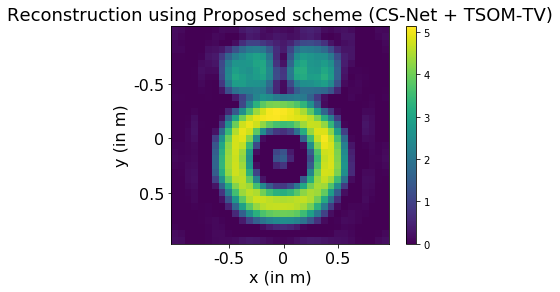

In [18]:
# Display Reconstruction of Austria Profile
plt.imshow(np.real(np.reshape(x_L,[L,L])))
plt.xticks([L*0.25, L*0.5, L*0.75], [-0.5, 0, 0.5],fontsize = '16')
plt.yticks([L*0.25, L*0.5, L*0.75], [-0.5, 0, 0.5],fontsize = '16')
plt.xlabel('x (in m)', fontsize='16')
plt.ylabel('y (in m)', fontsize='16')
plt.title('Reconstruction using Proposed scheme (CS-Net + TSOM-TV)', fontsize='18')
plt.colorbar()